<a href="https://colab.research.google.com/github/ASHIKAMOHAN/Image-Classification_with_Keras/blob/main/Image_Classification_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab for CW1: Image Classification with Keras


In [1]:
#Importing Libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import os
import PIL
from tensorflow.keras import datasets, layers, models
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import zipfile

In [2]:
#Mount drive from google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_file = "dataset_CW1.zip"
data_directory = "/content/drive/MyDrive/Image_Classification_with_Keras/Dataset/"
image_size = (128, 128)

In [ ]:
# ## DONT RUN THIS CELL !!!!!!!!!!!!!!!!!!!!!!!!
# #Unzipping the dataset file.
# zip_ref = zipfile.ZipFile(data_directory+zip_file, 'r')
# zip_ref.extractall(data_directory)
# zip_ref.close()

In [4]:
#Setting test and train folders
train_directory = os.path.join(data_directory, "seg_test/seg_test")
test_directory = os.path.join(data_directory, "seg_train/seg_train")
#list out folders in test and train datasets.
train_folders = os.listdir(train_directory)
test_folders = os.listdir(test_directory)
print(f'Train dataset : {train_folders} : Test dataset:{test_folders}')

Train dataset : ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea'] : Test dataset:['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [ ]:
def load_and_preprocess_data(directory, image_size):
    data = []  # Initialize a list to store image data
    labels = []  # Initialize a list to store image labels
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)# Get the full path to the category folder
        label = category  # Use the folder name as the label for all images in this folder
# Iterate through each image in the category folder
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)# Get the full path to the image
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            # Convert the image to a numpy array
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            image_array = image_array / 255.0  # Normalize the image data to 0-1 range
            data.append(image_array) # Append the processed image data to the data list
            labels.append(label) # Append the label to the labels list
    return np.array(data), np.array(labels)  # Convert the lists to numpy arrays for further processing in TensorFlow
# Load Train and Test data
train_images, train_labels = load_and_preprocess_data(train_directory, image_size)
test_images, test_labels = load_and_preprocess_data(test_directory, image_size)

In [6]:
# Print the shape of the data and labels arrays
print("Data shape:", train_images.shape)
print("Labels shape:", train_labels.shape)

Data shape: (3000, 128, 128, 3)
Labels shape: (3000,)


In [7]:
# Distribution of Data points among classes
import pandas as pd
freq = pd.Series(train_labels).value_counts()
print(freq)

glacier      553
mountain     525
sea          510
street       501
forest       474
buildings    437
dtype: int64


In [8]:
class_names = unique_labels = np.unique(train_labels)
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [9]:
class_to_index = {name: index for index, name in enumerate(class_names)}
index_to_class = {index: name for name, index in class_to_index.items()}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

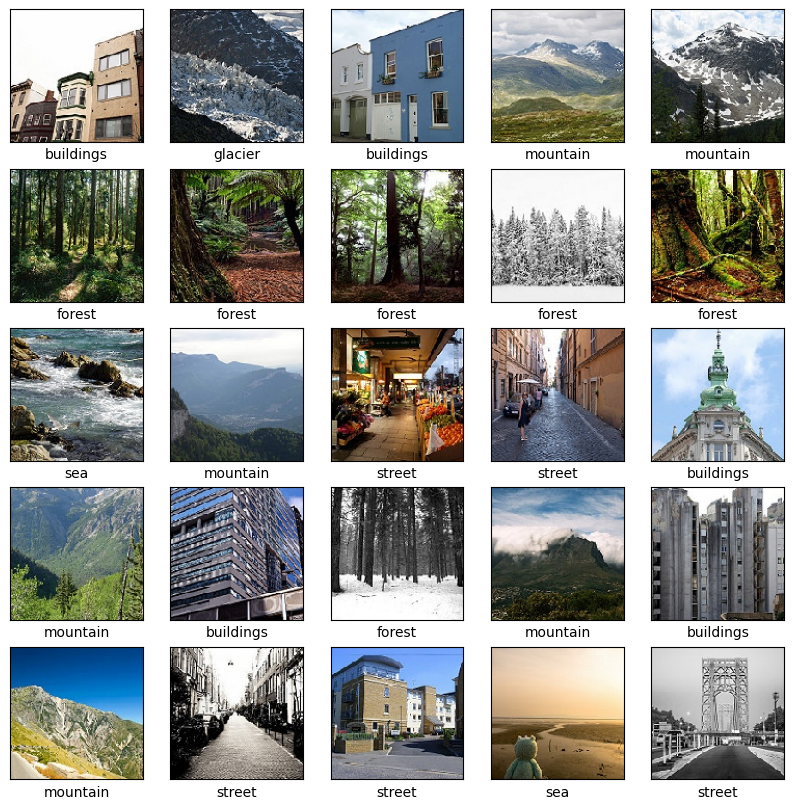

In [10]:
label_to_index = {label: index for index, label in enumerate(class_names)}

# Select 25 random image indices
random_indices = np.random.choice(len(train_images), size=25, replace=False)

plt.figure(figsize=(10,10))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_index])  # Use the random_index here
    label_index = label_to_index[train_labels[random_index]]  # And here
    plt.xlabel(class_names[label_index])
plt.show()

In [22]:
from tensorflow.keras.applications import MobileNet

In [23]:
VGG_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [24]:
# Iterate through each layer in the base model.
for layer in VGG_model.layers:
    # Set the layer's trainable attribute to False.
    # This action freezes the weights and biases of the layer during training, meaning they won't be updated.
    # Freezing the pre-trained layers is important in transfer learning because we want to retain the knowledge the model has already learned from the ImageNet dataset.
    layer.trainable = False

In [26]:
!pip install visualkeras
import visualkeras

ERROR: Operation cancelled by user


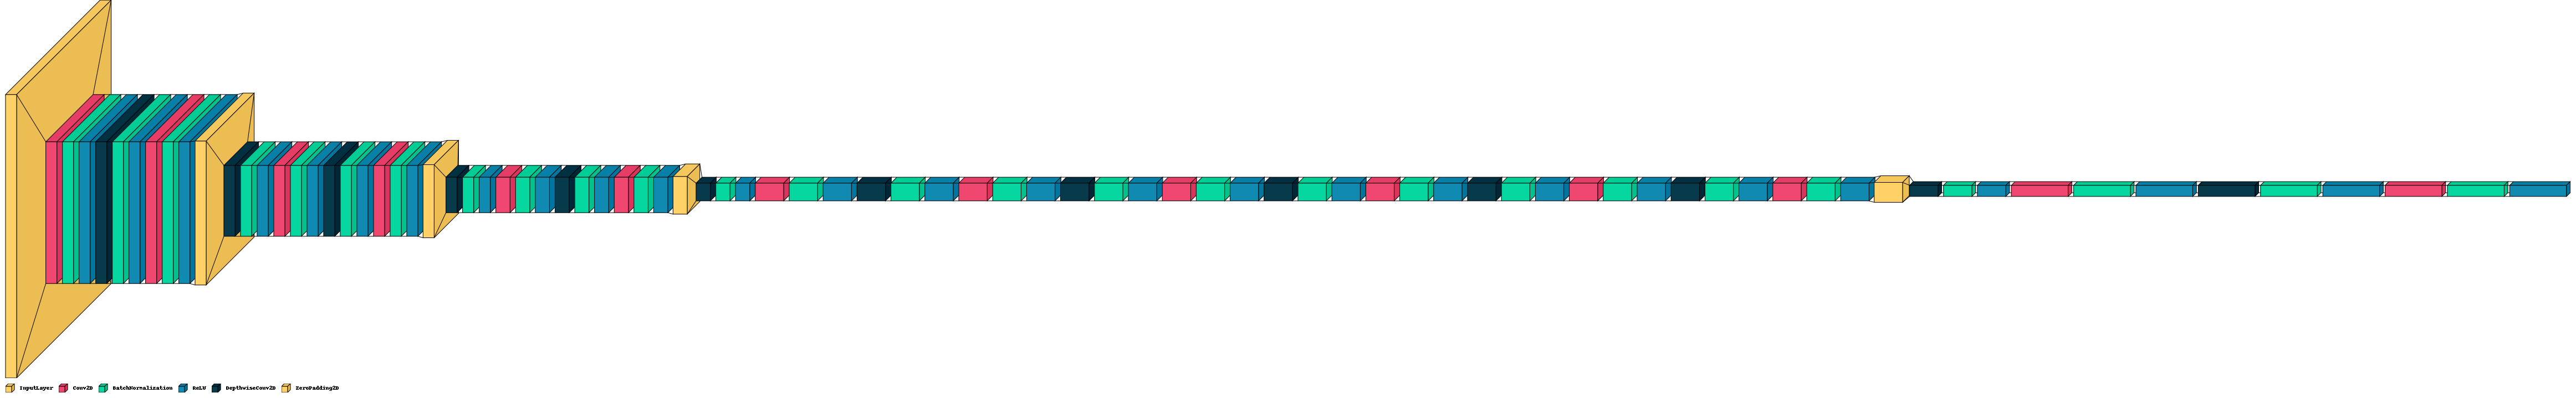

In [27]:
visualkeras.layered_view(VGG_model,legend=True)

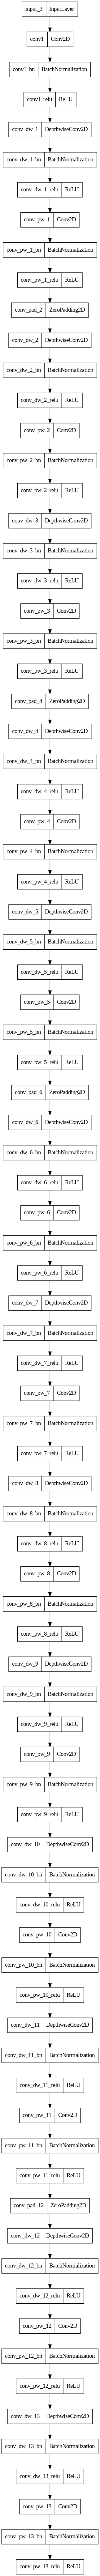

In [28]:
plot_model(VGG_model)

In [29]:
# `num_classes` will hold the total number of classes.
num_classes = len(class_names)

# Initialize a Sequential model.
model = models.Sequential()

# Add the pre-trained VGG16 model as the base of your model.
# This includes all the convolutional layers of VGG16, pre-trained on ImageNet.
model.add(VGG_model)

# Flatten the output of the VGG16 model because dense layers expect 1D inputs.
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu')) # Add a Dense (fully connected) layer to interpret the features extracted by VGG16.
# 256 neurons are used here, but this number can be adjusted depending on your dataset's complexity.
model.add(layers.Dropout(0.5)) # Add a Dropout layer to prevent overfitting
# Final Dense layer for classification. The number of neurons equals the number of classes,
# with a softmax activation function to output probabilities for each class.
model.add(layers.Dense(num_classes, activation='softmax'))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               4194560   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 7,424,966
Trainable params: 4,196,102
Non-trainable params: 3,228,864
____________________________________

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels_encoded , epochs=3,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/3
94/94 [==============================] - 137s 1s/step - loss: 0.4051 - accuracy: 0.8960 - val_loss: 0.4691 - val_accuracy: 0.9047
Epoch 2/3
94/94 [==============================] - 134s 1s/step - loss: 0.2992 - accuracy: 0.9250 - val_loss: 0.4296 - val_accuracy: 0.9140
Epoch 3/3
94/94 [==============================] - 132s 1s/step - loss: 0.1955 - accuracy: 0.9397 - val_loss: 0.3867 - val_accuracy: 0.9258


165/165 - 79s - loss: 0.3867 - accuracy: 0.9258 - 79s/epoch - 478ms/step


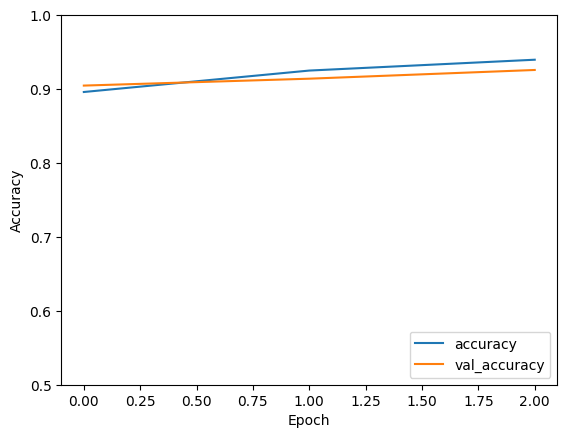

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels_encoded, verbose=2)

In [34]:
print(test_acc)

0.9257990717887878


165/165 [==============================] - 89s 534ms/step


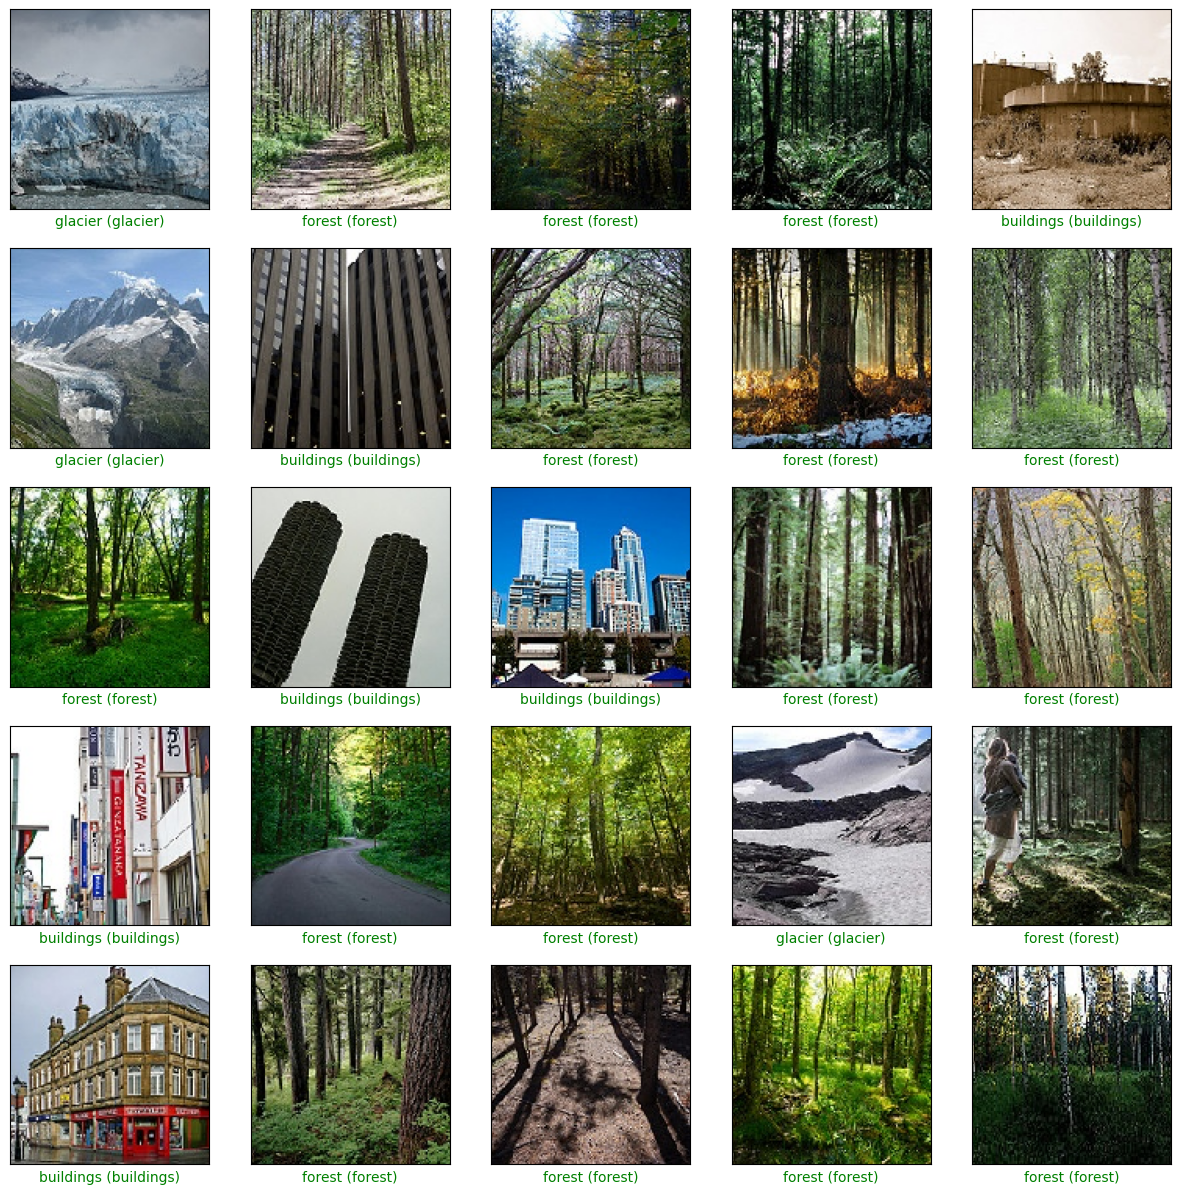

In [35]:
# First, get predictions for validation images
predicted_scores = model.predict(test_images)  # Note: We are using test_images as you named your validation set 'test'
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = {index: label for label, index in label_to_index.items()}

# Select 25 random image indices from the validation set
random_indices = np.random.choice(len(test_images), size=25, replace=False)

plt.figure(figsize=(15,15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    true_label = test_labels[random_index]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"{predicted_label} ({true_label})", color=color)  # Plotting predicted label (true label)
plt.show()

In [36]:
test_labels

array(['forest', 'forest', 'forest', ..., 'glacier', 'glacier', 'glacier'],
      dtype='<U9')

In [37]:
# Convert numerical labels back to class names
# Convert numerical labels back to class names
predicted_labels = [index_to_label[index] for index in predicted_labels]

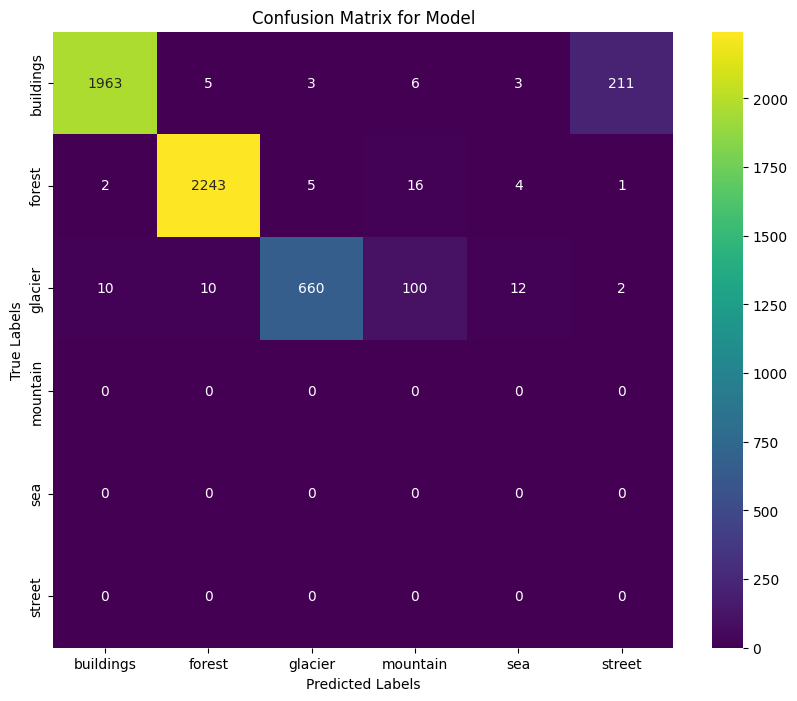

In [41]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix using a heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
            yticklabels=[index_to_label[i] for i in range(len(index_to_label))])
plt.title('Confusion Matrix for Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()